In [1]:
import pickle

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
sns.set_style("whitegrid")

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
import sqlite3
import pandas as pd

In [107]:
import datetime
cutoff1 = datetime.datetime(2015, 6, 1)

In [10]:
import re

In [8]:
conn = sqlite3.connect('crossvalidated.db')

In [12]:
# return all the records for questions posts from posts table
ques_query = "SELECT * FROM posts WHERE PostTypeId==1"

In [13]:
qpost_df = pd.read_sql_query(ques_query, conn)

In [14]:
qpost_df.shape

(75067, 21)

In [7]:
# return all the records for answer posts from posts table
ans_query = "SELECT * FROM posts WHERE PostTypeId==2"

In [9]:
apost_df = pd.read_sql_query(ans_query, conn)

In [66]:
post_df = pd.concat([qpost_df,apost_df])

In [19]:
apost_df.head()

,Body,ViewCount,LastEditorDisplayName,ClosedDate,CommunityOwnedDate,LastEditorUserId,ParentID,LastEditDate,CommentCount,AnswerCount,...,Score,OwnerDisplayName,Title,PostTypeId,OwnerUserId,Tags,CreationDate,FavoriteCount,Id,LastActivityDate
0,"<p>The R-project</p>\n\n<p><a href=""http://www...",None,None,None,2010-07-19T19:14:43.050,23.0,3,2010-07-19T19:21:15.063,3,None,...,84,None,None,2,23.0,None,2010-07-19 19:14:43.050,None,5,2010-07-19T19:21:15.063
1,"<p><a href=""http://incanter.org/"">Incanter</a>...",None,None,None,2010-07-19T19:16:27.553,NaN,3,None,3,None,...,13,None,None,2,50.0,None,2010-07-19 19:16:27.553,None,9,2010-07-19T19:16:27.553
2,"<p>See my response to <a href=""http://stackove...",None,None,None,2011-08-12T20:29:33.010,NaN,7,None,1,None,...,20,None,None,2,5.0,None,2010-07-19 19:18:41.370,None,12,2010-07-19T19:18:41.370
3,<p>Machine Learning seems to have its basis in...,None,None,None,None,NaN,6,None,4,None,...,16,None,None,2,23.0,None,2010-07-19 19:18:56.800,None,13,2010-07-19T19:18:56.800
4,<p>I second that Jay. Why is R valuable? Here'...,None,None,None,2010-07-19T19:19:03.990,NaN,3,None,1,None,...,5,None,None,2,36.0,None,2010-07-19 19:19:03.990,None,14,2010-07-19T19:19:03.990


In [17]:
qpost_df.CreationDate = pd.to_datetime(qpost_df.CreationDate)
apost_df.CreationDate = pd.to_datetime(apost_df.CreationDate)

###Accepted by Originator Votes

In [20]:
def getAnsCount(row):
    records = apost_df[(apost_df['OwnerUserId']== row['OwnerUserId']) & (apost_df['CreationDate']< row['CreationDate'])]
    return records.shape[0]

In [21]:
#Accepted by Originator Votes
tt = qpost_df.apply(getAnsCount,axis=1)

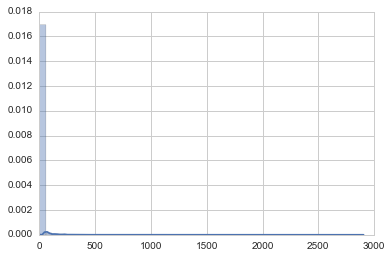

In [26]:
sns.distplot(tt, rug=False)

In [27]:
#qpost_df = qpost_df.merge(tt, left_index=True, right_index=True)

###Approved Edited Suggestions Count

In [31]:
# return all the records for questions posts from posts table
posthist_query = "SELECT PostHistoryTypeId,CreationDate,UserId FROM posthistory"
posthist_df = pd.read_sql_query(posthist_query, conn)
posthist_df.CreationDate = pd.to_datetime(posthist_df.CreationDate)

In [34]:
postsedited = posthist_df[posthist_df['PostHistoryTypeId'].isin([4,5,6])]

In [35]:
def getAppEditsCount(row):    
    records = postsedited[(postsedited['UserId']== row['OwnerUserId']) & (postsedited['CreationDate']< row['CreationDate'])]
    return records.shape[0]

In [36]:
#Approved Edited Suggestions Count
AESC = qpost_df.apply(getAppEditsCount,axis=1)

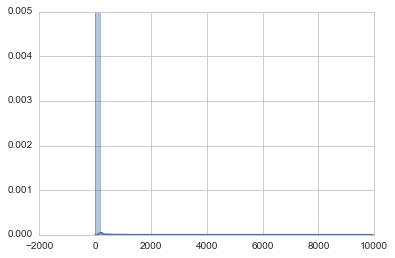

In [37]:
sns.distplot(AESC, rug=False)

In [40]:
AESC.value_counts().head()

0    46605
1     6041
2     3829
3     2628
4     1869
dtype: int64

###Total Badge Count

In [47]:
# return all the records from badges table
badges_query = "SELECT Name,Date,UserId FROM badges"
badges_df = pd.read_sql_query(badges_query, conn)
badges_df.Date = pd.to_datetime(badges_df.Date)

In [50]:
badges_df.shape

(159170, 3)

In [49]:
#target = ['Great Answer', 'Good Answer', 'Nice Answer','Favorite Question', 'Stellar Question', 'Good Question','Nice Question']
#badges_df = badges_df[badges_df['Name'].isin(target)]  
#relatively small set, count all the badges received by the user

In [53]:
def getBadgeCount(row):    
    records = badges_df[(badges_df['UserId']== row['OwnerUserId']) & (badges_df['Date']< row['CreationDate'])]
    return records.shape[0]

In [54]:
#Total Badge Count
TBC = qpost_df.apply(getBadgeCount,axis=1)

In [57]:
TBC.value_counts().head()

0    30974
1     8000
2     5546
3     4842
4     4472
dtype: int64

###Total Close and Deletion Votes

In [70]:
# return all the records from votes table
votes_query = "SELECT VoteTypeId,CreationDate,PostId,UserId FROM votes"
votes_df = pd.read_sql_query(votes_query, conn)
votes_df.CreationDate = pd.to_datetime(votes_df.CreationDate)

In [71]:
votes_df = votes_df[votes_df['VoteTypeId'].isin([6,10])]

In [72]:
def getTCDVCount(row):    
    postid_target = post_df[(post_df['OwnerUserId']== row['OwnerUserId'])&(post_df['CreationDate']< row['CreationDate'])].Id.tolist()
    records = votes_df[(votes_df['PostId'].isin(postid_target)) & (votes_df['CreationDate']< row['CreationDate'])]
    return records.shape[0]

In [73]:
#Total Close and Deletion Votes¶
TCDV = qpost_df.apply(getTCDVCount,axis=1)

In [74]:
TCDV.value_counts()

0    73439
1      820
5      298
2      212
3      167
4       70
9       34
6       19
7        8
dtype: int64

###Total Up Votes received

In [75]:
# return all the records from votes table
votes_query = "SELECT VoteTypeId,CreationDate,PostId,UserId FROM votes"
votes_df = pd.read_sql_query(votes_query, conn)
votes_df.CreationDate = pd.to_datetime(votes_df.CreationDate)

In [76]:
votes_df = votes_df[votes_df['VoteTypeId']==2]

In [77]:
def getUpVoteCount(row):    
    #get the past post ids from the user
    postid_target = post_df[(post_df['OwnerUserId']== row['OwnerUserId'])&(post_df['CreationDate']< row['CreationDate'])].Id.tolist()
    records = votes_df[(votes_df['PostId'].isin(postid_target)) & (votes_df['CreationDate']< row['CreationDate'])]
    return records.shape[0]

In [78]:
#Total Up Votes by the time of new post
TUVC = qpost_df.apply(getTCDVCount,axis=1)

In [81]:
TUVC.value_counts().head()

0    37767
1     4462
2     3510
3     2846
4     2342
dtype: int64

###Total Down Votes received

In [82]:
# return all the records from votes table
votes_query = "SELECT VoteTypeId,CreationDate,PostId,UserId FROM votes"
votes_df = pd.read_sql_query(votes_query, conn)
votes_df.CreationDate = pd.to_datetime(votes_df.CreationDate)
votes_df = votes_df[votes_df['VoteTypeId']==3]

In [83]:
def getDownVoteCount(row):    
    #get the past post ids from the user
    postid_target = post_df[(post_df['OwnerUserId']== row['OwnerUserId'])&(post_df['CreationDate']< row['CreationDate'])].Id.tolist()
    records = votes_df[(votes_df['PostId'].isin(postid_target)) & (votes_df['CreationDate']< row['CreationDate'])]
    return records.shape[0]

In [84]:
#Total Up Votes by the time of new post
TDVC = qpost_df.apply(getDownVoteCount,axis=1)

In [85]:
TDVC.value_counts().head()

0    64023
1     5436
2     2054
3     1076
4      709
dtype: int64

###Total Favorite Votes received

In [90]:
votes_query = "SELECT VoteTypeId,CreationDate,PostId,UserId FROM votes WHERE VoteTypeId==5"
votes_df = pd.read_sql_query(votes_query, conn)
votes_df.CreationDate = pd.to_datetime(votes_df.CreationDate)

In [91]:
def getFavVoteCount(row):    
    #get the past post ids from the user
    postid_target = post_df[(post_df['OwnerUserId']== row['OwnerUserId'])&(post_df['CreationDate']< row['CreationDate'])].Id.tolist()
    records = votes_df[(votes_df['PostId'].isin(postid_target)) & (votes_df['CreationDate']< row['CreationDate'])]
    return records.shape[0]

In [92]:
#Total Up Votes by the time of new post
TFVC = qpost_df.apply(getFavVoteCount,axis=1)

In [93]:
TFVC.value_counts().head()

0    51902
1     6202
2     3626
3     2073
4     1493
dtype: int64

##Integrate all the Popularity Metrics features

In [94]:
qpost_df['AccpAnsCnt'] = tt
qpost_df['AppEditCnt'] = AESC
qpost_df['BadgeCnt'] = TBC
qpost_df['CloDelVCnt'] = TCDV
qpost_df['UpVoteCnt'] = TUVC
qpost_df['DownVoteCnt'] = TDVC
qpost_df['FavVoteCnt'] = TFVC

In [97]:
target_cols = ['Id','CreationDate','OwnerUserId','AccpAnsCnt','AppEditCnt','BadgeCnt','CloDelVCnt','UpVoteCnt',\
               'DownVoteCnt','FavVoteCnt','Score']

In [98]:
popularity_metric_df = qpost_df[target_cols]

In [102]:
popularity_metric_df.head(10)

,Id,CreationDate,OwnerUserId,AccpAnsCnt,AppEditCnt,BadgeCnt,CloDelVCnt,UpVoteCnt,DownVoteCnt,FavVoteCnt,Score
0,1,2010-07-19 19:12:12.510,8.0,0,0,0,0,0,0,0,31
1,2,2010-07-19 19:12:57.157,24.0,0,0,0,0,0,0,0,26
2,3,2010-07-19 19:13:28.577,18.0,0,0,0,0,0,0,0,63
3,4,2010-07-19 19:13:31.617,23.0,0,0,0,0,0,0,0,15
4,6,2010-07-19 19:14:44.080,5.0,0,0,0,0,0,0,0,226
5,7,2010-07-19 19:15:59.303,38.0,0,0,0,0,0,0,0,87
6,8,2010-07-19 19:16:21.737,37.0,0,0,0,0,0,0,0,0
7,10,2010-07-19 19:17:47.537,24.0,0,0,0,0,6,0,0,32
8,11,2010-07-19 19:18:30.810,34.0,0,0,0,0,0,0,0,3
9,17,2010-07-19 19:24:12.187,NaN,0,0,0,0,0,0,0,10


In [99]:
import pickle
with open('popularity_metric.pickle', 'wb') as handle:
    pickle.dump(popularity_metric_df, handle)